# Импорты

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [37]:
!pip install catboost
from catboost import CatBoostRegressor

import random

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor

from google.colab import files

# Обработка данных

In [28]:
# Работа с данными
def change_df(dff, is_submit):
    if (is_submit == 0):
        dff = dff.drop_duplicates()
        price_doc = dff['price_doc']
        dff.drop('price_doc', axis=1, inplace=True)

    dff['full_sq'][(dff['full_sq'] > 1000)] = 45
    dff['full_sq'][(dff['full_sq'] > 250)] = dff['full_sq'] / 10
    dff['full_sq'][(dff['full_sq'] == 0)] = 1
    dff['full_sq'][(dff['full_sq'] == 1)] = 66
    dff['full_sq'][(dff['full_sq'] == 5) | (dff['full_sq'] == 6)] = 45
    dff['full_sq'][(dff['full_sq'] == 9)] = 52

    dff['fixed_floor'] = 0
    dff.loc[dff['floor'] > 30, 'fixed_floor'] = 1
    dff.loc[dff['floor'] == 0, 'fixed_floor'] = -1
    dff['floor'][(dff['floor'] > 30)] = 30

    dff['school_km'][(dff['school_km'] > 10)] = np.sqrt(np.sqrt(dff['school_km'])) + 8
    dff['fitness_km'][(dff['fitness_km'] > 5)] = np.sqrt(np.sqrt(dff['fitness_km'])) + 3.5
    dff['cemetery_km'][(dff['cemetery_km'] > 5.75)] = np.sqrt(np.sqrt(dff['cemetery_km'])) + 3.5
    dff['industrial_km'][(dff['industrial_km'] > 2.8)] = 2.8

    dff['metro_min_avto'][(dff['metro_min_avto'] > 30)] = np.sqrt(np.sqrt(dff['metro_min_avto'])) + 27
    dff['metro_min_avto'][(dff['metro_min_avto'] > 10)] = np.sqrt(np.sqrt(dff['metro_min_avto'])) + 2.5

    dff['mosque_km'][(dff['mosque_km'] < -1)] = np.abs(dff['mosque_km']) * 0.35
    dff['ttk_km'][(dff['ttk_km'] < -2)] = np.abs(dff['ttk_km']) * 0.35
    dff['theater_km'][(dff['theater_km'] < -1.5)] = np.abs(dff['theater_km']) * 0.35
    dff['theater_km'][(dff['theater_km'] > 3.5)] = np.sqrt(np.sqrt(dff['theater_km'])) + 2.5
    dff['market_shop_km'][(dff['market_shop_km'] < -2.5)] = 0
    dff['market_shop_km'][(dff['market_shop_km'] > 3)] = 0

    dff['catering_km'][(dff['catering_km'] <- 6)] = -6
    dff['catering_km'][(dff['catering_km'] < 0)] = np.sqrt(np.abs(dff['catering_km']))

    dff['kitch_sq'][(dff['kitch_sq'] > dff['full_sq'])] = 0.15 * dff['kitch_sq'] / dff['full_sq']

    dff['additional_education_km'][(dff['additional_education_km'] > 6)] = np.sqrt(np.sqrt(dff['additional_education_km'])) + 4

    dff['fixed_year'] = 0
    dff.loc[dff['build_year'] <= 1850, 'fixed_year'] = 1
    dff.loc[dff['build_year'] > 2024, 'fixed_year'] = -1
    dff['build_year'][(dff['build_year'] > 2024)] = 2005
    dff['build_year'][(dff['build_year'] < 1850)] = 1960

    dff.drop('kitch_sq', axis=1, inplace=True)

    dff['mosque_count'] = np.sqrt(np.abs(dff['mosque_count_3000'] * dff['mosque_count_5000']))
    dff.drop('mosque_count_3000', axis=1, inplace=True)
    dff.drop('mosque_count_5000', axis=1, inplace=True)

    dff['ExpensiveMeter1'] = dff['full_sq'] * dff['num_room']
    dff['ExpensiveMeter1'][(dff['ExpensiveMeter1'] > 700)] = 700
    dff['ExpensiveMeter1'][(dff['ExpensiveMeter1'] < 25)] = 25
    dff['ExpensiveMeter2'] = dff['radiation_raion'] * np.sqrt(dff['full_sq']
                                                              )
    dff['Test2'] = dff['product_type'] + dff['radiation_raion']
    dff['Test3'] = dff['num_room'] * dff['raion_popul']
    dff['Test4'] = (dff['product_type']+2) * np.sqrt(dff['full_sq'])
    dff['Test5'] = np.minimum(dff['cemetery_km'], dff['oil_chemistry_km']) * dff['full_sq']
    dff['Test6'] = dff['indust_part'] * dff['raion_popul']
    dff['Test7'] = dff['stadium_km'] * dff['basketball_km']
    dff['Test8'] = dff['sport_objects_raion'] * dff['shopping_centers_raion']
    dff['Test9'] = dff['cafe_sum_1000_min_price_avg'] * dff['cafe_sum_1500_min_price_avg']

    dff['Room_area'] = dff['full_sq'] / (dff['num_room'] + 1)
    dff['build_age'] = dff['year'] - dff['build_year']

    dff['full_sq2'] = np.floor(dff['full_sq'] / 20) * 20
    dff['ttk_km2'] = np.floor(dff['ttk_km'] * 2) / 2
    dff['school_km2'] = np.floor(dff['school_km'] * 2) / 2
    dff['theater_km2'] = np.floor(dff['theater_km'] * 2) / 2
    dff['cemetery_km2'] = np.floor(dff['cemetery_km'] * 2) / 2
    dff['fitness_km2'] = np.floor(dff['fitness_km'] * 2) / 2
    dff['market_shop_km2'] = np.floor(dff['market_shop_km'] * 2) / 2
    dff['additional_education_km2'] = np.floor(dff['additional_education_km'] * 2) / 2
    dff['raion_popul2'] = np.floor(dff['raion_popul'] * 2) / 2
    dff['build_year2'] = np.floor(dff['build_year'] / 15) * 15
    dff['build_age2'] = np.floor(dff['build_age'] / 10) * 10
    dff['floor2'] = np.floor(dff['floor'] / 5) * 5
    dff['shopping_centers_raion2'] = np.floor(dff['shopping_centers_raion'] / 5) * 5
    dff['build_count_block2'] = np.floor(dff['build_count_block'] / 25) * 25
    dff['build_count_brick2'] = np.floor(dff['build_count_brick'] / 25) * 25
    dff['build_count_monolith2'] = np.floor(dff['build_count_monolith'] / 20) * 20
    dff['metro_min_avto2'] = np.floor(dff['metro_min_avto'] / 1.5) * 1.5
    dff['green_zone_km2'] = np.floor(dff['green_zone_km']/ 0.3) * 0.3
    dff['industrial_km2'] = np.floor(dff['industrial_km'] / 0.3) * 0.3
    dff['water_treatment_km2'] = np.floor(dff['water_treatment_km'] / 0.4) * 0.4
    dff['incineration_km2'] = np.floor(dff['incineration_km'] / 0.5) * 0.5
    dff['ID_railroad_station_avto2'] = np.floor(dff['ID_railroad_station_avto'] / 0.5) * 0.5
    dff['mkad_km2'] = np.floor(dff['mkad_km'] / 0.75) * 0.75
    dff['oil_chemistry_km2'] = np.floor(dff['oil_chemistry_km'] / 0.6) * 0.6
    dff['nuclear_reactor_km2'] = np.floor(dff['nuclear_reactor_km'] / 0.6) * 0.6
    dff['power_transmission_line_km2'] = np.floor(dff['power_transmission_line_km'] / 0.6) * 0.6
    dff['basketball_km2'] = np.floor(dff['basketball_km'] / 0.6) * 0.6
    dff['detention_facility_km2'] = np.floor(dff['detention_facility_km'] / 0.6) * 0.6
    dff['catering_km2'] = np.floor(dff['catering_km'] / 0.4) * 0.4
    dff['mosque_km2'] = np.floor(dff['mosque_km'] / 0.5) * 0.5
    dff['exhibition_km2'] = np.floor(dff['exhibition_km'] / 0.75) * 0.75
    dff['big_church_km2'] = np.floor(dff['big_church_km'] / 0.75) * 0.75
    dff['cafe_sum_1000_min_price_avg2'] = np.floor(dff['cafe_sum_1000_min_price_avg'] / 0.5) * 0.5
    dff['cafe_sum_1500_min_price_avg2'] = np.floor(dff['cafe_sum_1500_min_price_avg'] / 0.5) * 0.5
    dff['cafe_sum_2000_min_price_avg2'] = np.floor(dff['cafe_sum_2000_min_price_avg'] / 0.75) * 0.75
    dff['cafe_sum_5000_min_price_avg2'] = np.floor(dff['cafe_sum_2000_min_price_avg'] / 0.3) * 0.3
    dff['green_part_10002'] = np.floor(dff['green_part_1000'] / 15) * 15
    dff['green_part_20002'] = np.floor(dff['green_part_2000'] / 0.8) * 0.8
    dff['prom_part_50002'] = np.floor(dff['prom_part_5000'] / 0.4) * 0.4
    dff['Room_area2'] = np.floor(dff['Room_area'] / 15) * 15

    if (is_submit == 0):
        dff['price_doc'] = price_doc

    return dff

# Подготовка к тренировке

In [6]:
df = pd.read_csv('./gdrive/MyDrive/shift 2/train.csv', index_col=0)
df = change_df(df, False)
df

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,full_sq,floor,build_year,num_room,state,product_type,raion_popul,indust_part,sport_objects_raion,shopping_centers_raion,...,big_church_km2,cafe_sum_1000_min_price_avg2,cafe_sum_1500_min_price_avg2,cafe_sum_2000_min_price_avg2,cafe_sum_5000_min_price_avg2,green_part_10002,green_part_20002,prom_part_50002,Room_area2,price_doc
0,43.0,24.0,2014.0,1.0,1.0,1,8.294300,0.007122,0,1,...,0.00,6.5,6.5,6.00,6.6,30.0,3.2,1.6,15.0,5533460
1,66.0,3.0,1979.0,3.0,3.0,0,11.314231,0.232205,4,3,...,-0.75,6.5,6.5,6.00,6.3,15.0,2.4,2.4,15.0,9900000
2,55.0,5.0,1979.0,2.0,2.0,0,11.718817,0.000170,5,1,...,-0.75,6.5,6.0,6.00,6.0,0.0,3.2,1.2,15.0,1990000
3,45.0,7.0,1970.0,2.0,2.0,0,11.331032,0.428826,4,2,...,0.00,6.5,6.5,6.00,6.3,0.0,1.6,2.4,15.0,6500000
4,43.0,4.0,1968.0,2.0,2.0,0,11.538769,0.136330,6,6,...,0.00,6.5,6.5,6.00,6.6,0.0,1.6,2.0,0.0,8500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21324,56.0,19.0,1979.0,2.0,1.0,1,11.655744,0.049637,6,3,...,0.75,5.5,6.0,6.75,6.6,0.0,2.4,3.2,15.0,10159562
21325,42.0,5.0,1977.0,1.0,3.0,0,11.718817,0.000170,5,1,...,-0.75,6.0,6.5,6.00,6.0,30.0,3.2,1.2,15.0,5100000
21326,32.0,3.0,1979.0,2.0,2.0,0,11.719940,0.000000,4,2,...,-0.75,6.0,6.5,6.00,6.3,0.0,2.4,2.4,0.0,4800000
21327,43.0,4.0,1969.0,2.0,2.0,0,11.331032,0.428826,4,2,...,0.00,6.5,6.5,6.00,6.3,15.0,2.4,2.8,0.0,6300000


# Модели

In [7]:
model_cat = CatBoostRegressor(
    learning_rate= 0.1,
    l2_leaf_reg= 5,
    iterations= 550,
    depth= 8,
    loss_function='RMSE',
    verbose=0
  )

In [8]:
import lightgbm as lgb
params_lgb = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'verbose': -1,
    'num_leaves': 15,
    'n_estimators': 3000,
    'max_depth': 10,
    'learning_rate': 0.01,
    'bagging_fraction': 0.5
}
model_lgb = lgb.LGBMRegressor(**params_lgb)

In [9]:
model_xgboost = XGBRegressor(
    min_child_weight=0,
    subsample=0.7,
    colsample_bytree=0.7,
    objective='reg:squarederror',
    nthread=-1,
    scale_pos_weight=1,
    reg_alpha=0.00006,
    n_estimators=2500,
    max_depth=6,
    learning_rate= 0.009,
    gamma= 0.01
  )

In [10]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [12]:
avg_rmse_xgboost = 0
avg_rmse_lgb = 0
avg_rmse_cat = 0

# Обучение

In [13]:
# Количество прогонов тренировок моделей.
# Если > 1, то предполагается, что оцениваются / сравниваются модели
# на большой выборке прогонов
iters = 1

for j in range(iters):
    print('Итерация № ' + str(j + 1) + ' / ' + str(iters))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0001, random_state=42)

    model_xgboost.fit(X_train,y_train)
    y_pred_model_xgboost = model_xgboost.predict(X_test)
    print(f"xgboost: {np.sqrt(mean_squared_error(y_test, y_pred_model_xgboost)):.0f}")

    model_lgb.fit(X_train,y_train)
    y_pred_model_lgb = model_lgb.predict(X_test)
    print(f"lgb: {np.sqrt(mean_squared_error(y_test, y_pred_model_lgb)):.0f}")

    model_cat.fit(X_train,y_train)
    y_pred_model_cat = model_cat.predict(X_test)
    print(f"cat: {np.sqrt(mean_squared_error(y_test, y_pred_model_cat)):.0f}")

    avg_rmse_xgboost += np.sqrt(mean_squared_error(y_test, y_pred_model_xgboost)) / iters
    avg_rmse_lgb += np.sqrt(mean_squared_error(y_test, y_pred_model_lgb)) / iters
    avg_rmse_cat += np.sqrt(mean_squared_error(y_test, y_pred_model_cat)) / iters

    best_mean = np.round(min(avg_rmse_xgboost, avg_rmse_lgb, avg_rmse_cat) * iters / (j + 1), 0)

    print('Лучшее среднее модельки: ' + str(best_mean))


Итерация № 1/1
xgboost: 710309
lgb: 742865
cat: 736293
Лучшее среднее модельки: 710309.0


In [14]:
# Вывод результатов
print("РЕЗУЛЬТАТЫ ОБУЧЕНИЯ")
print(f"Среднее rmse для xgboost: {avg_rmse_xgboost:.0f}")
print(f"Среднее rmse для lgb: {avg_rmse_lgb:.0f}")
print(f"Среднее rmse для cat: {avg_rmse_cat:.0f}")


ИТОГИ
Среднее rmse для xgboost: 710309
Среднее rmse для lgb: 742865
Среднее rmse для cat: 736293


# Мониторинг

<Axes: >

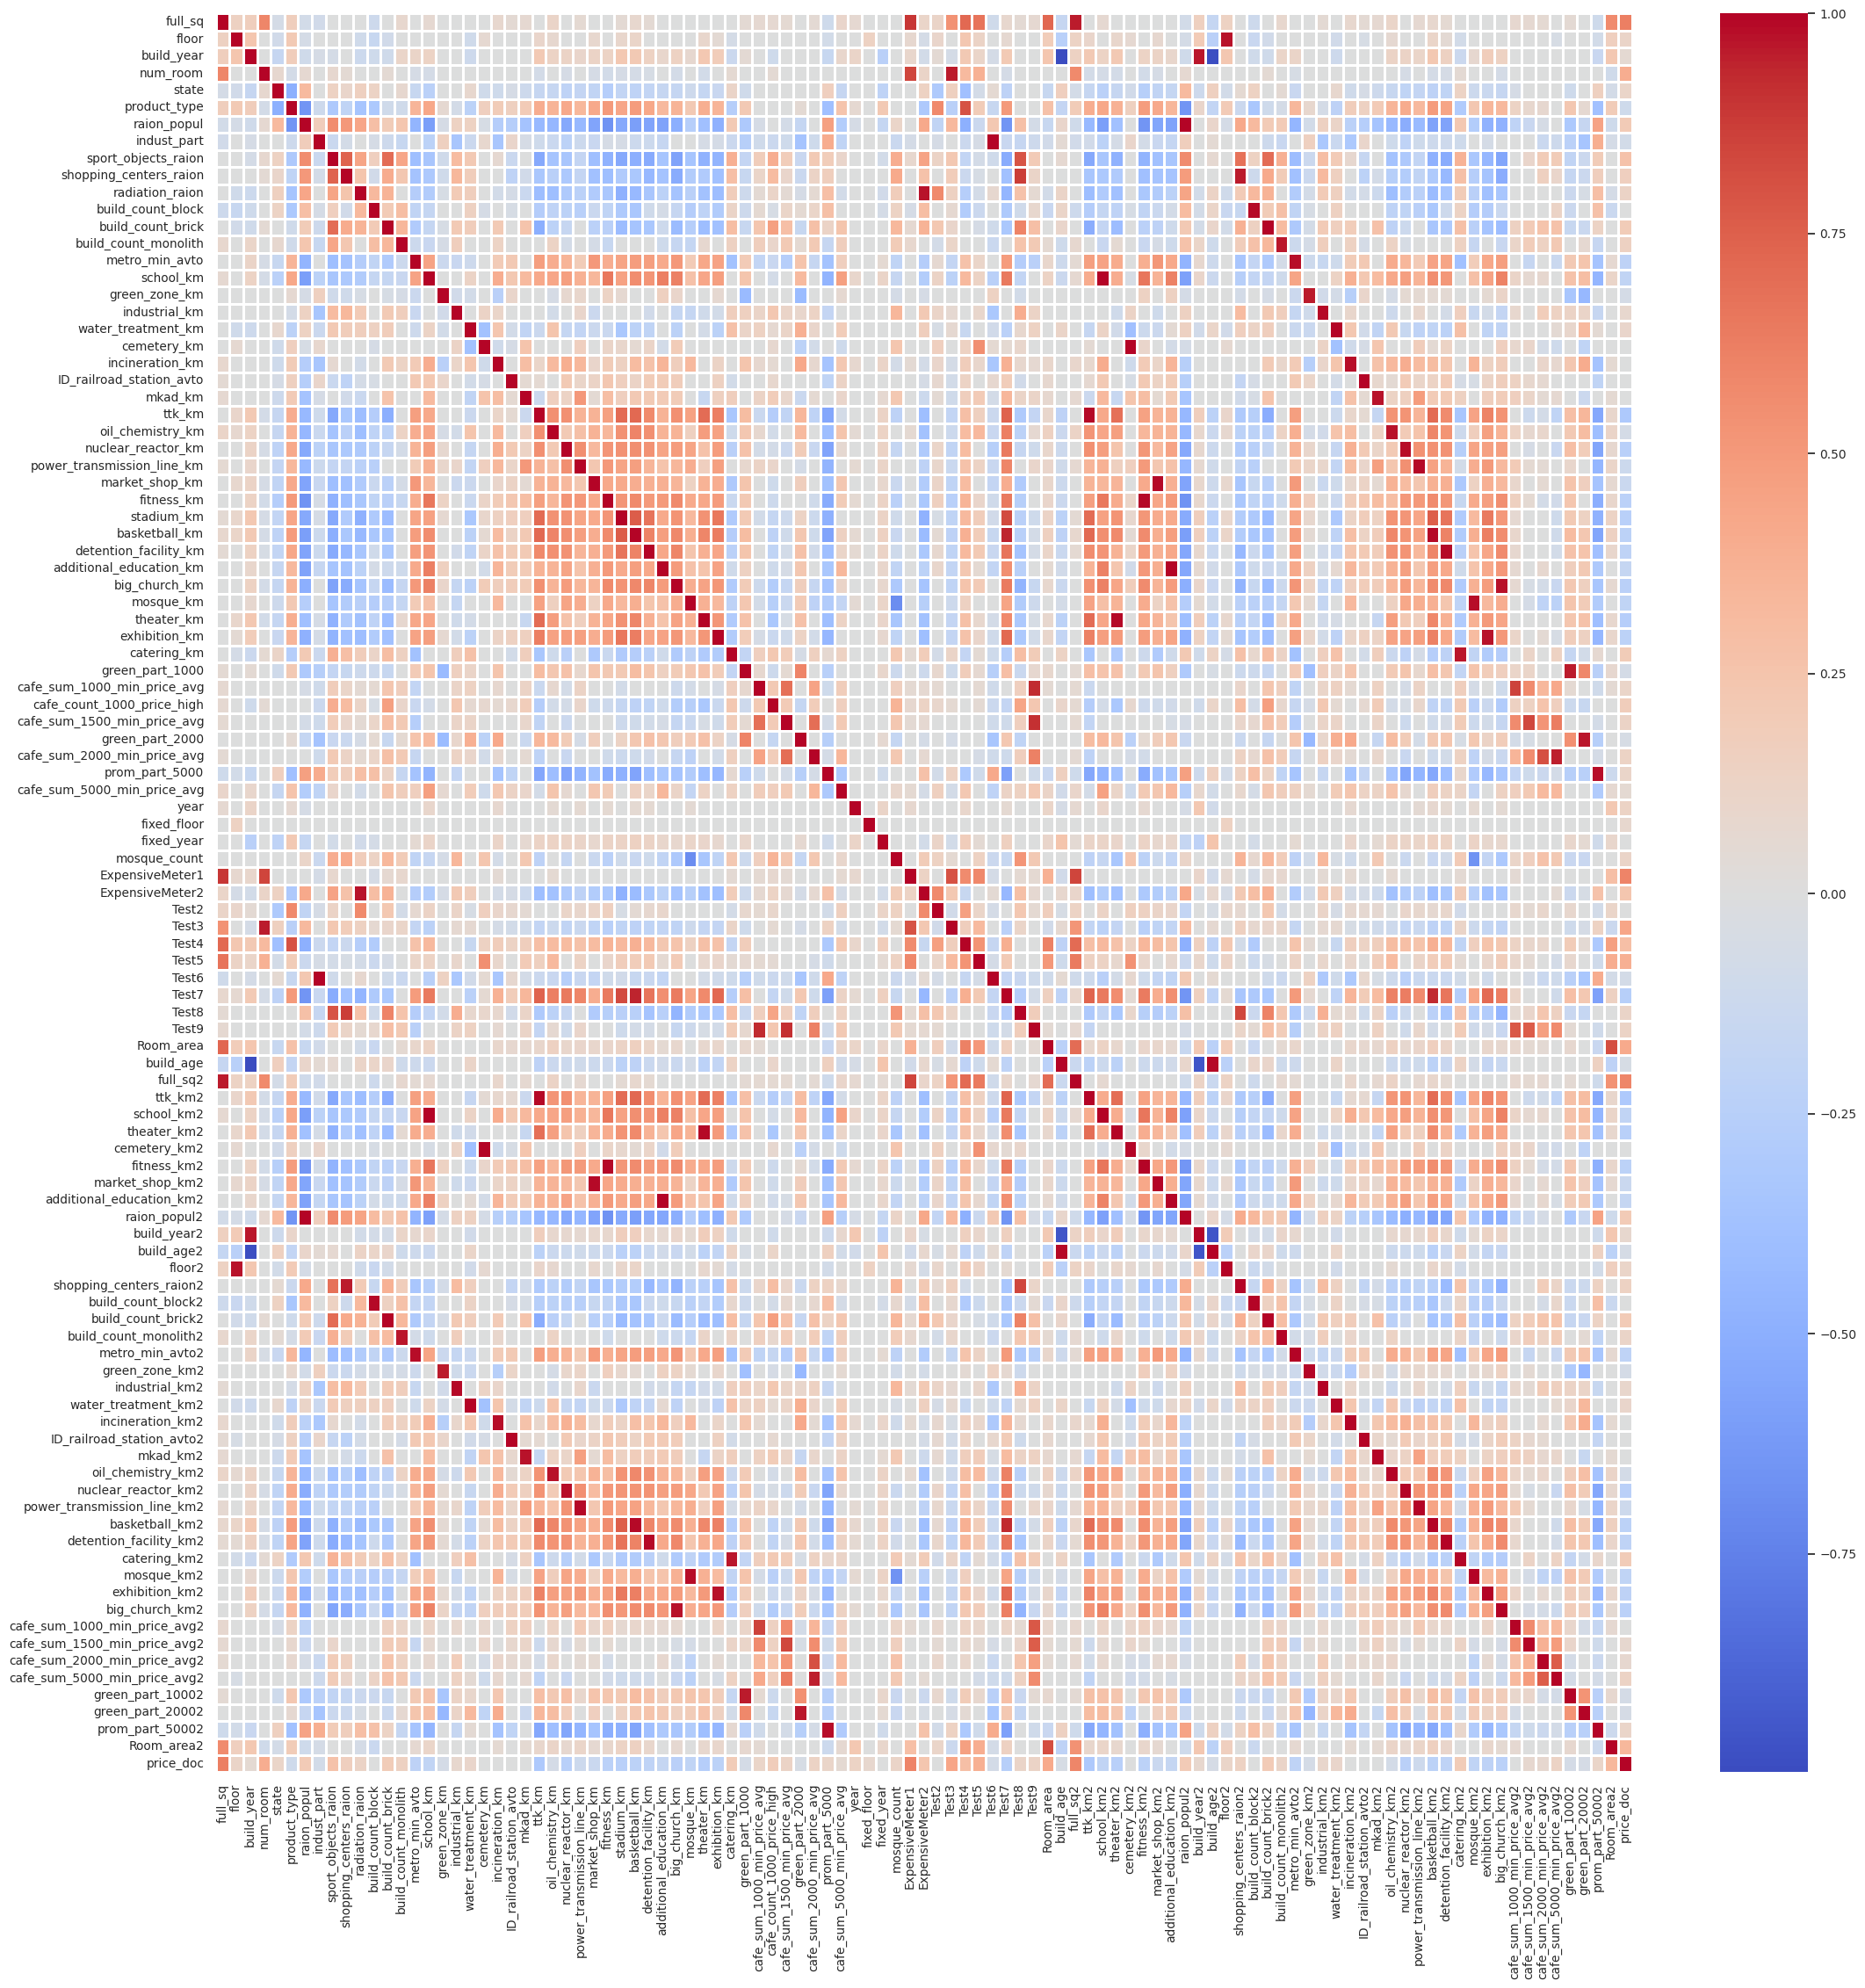

In [16]:
plt.figure(figsize=(26,26))
sns.set(font_scale=.9)
dfCorr = df.corr()
dfCorr[np.abs(dfCorr) < 0.05] = 0
sns.heatmap(dfCorr, linewidths=2, cmap='coolwarm')

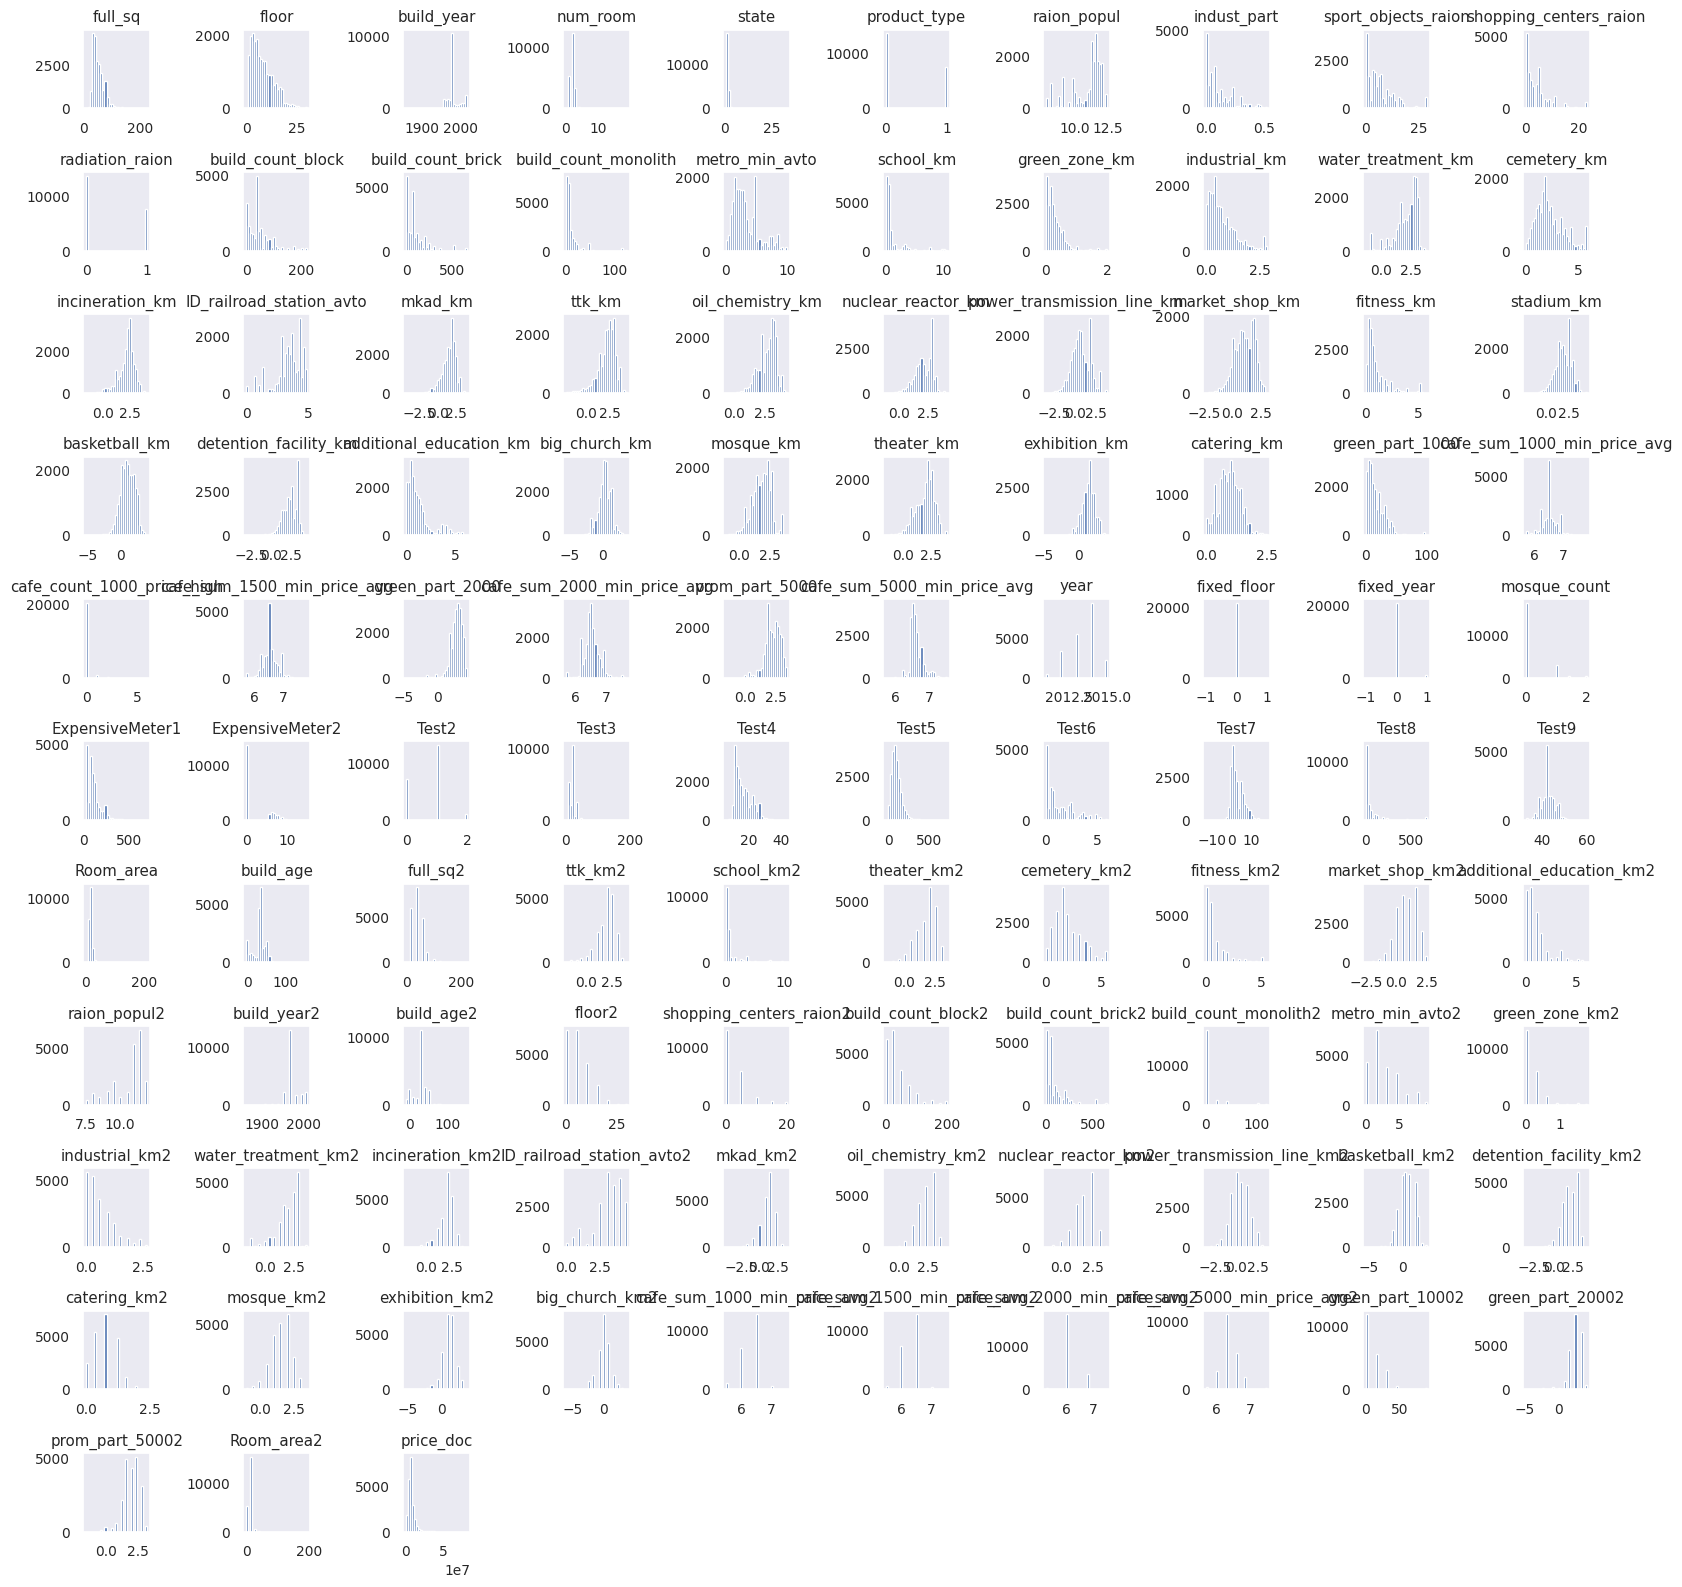

In [17]:
df.select_dtypes(include=['float64', 'float32', 'float16','int64']).hist(figsize=(16,16), bins=30, grid=False)
plt.tight_layout()

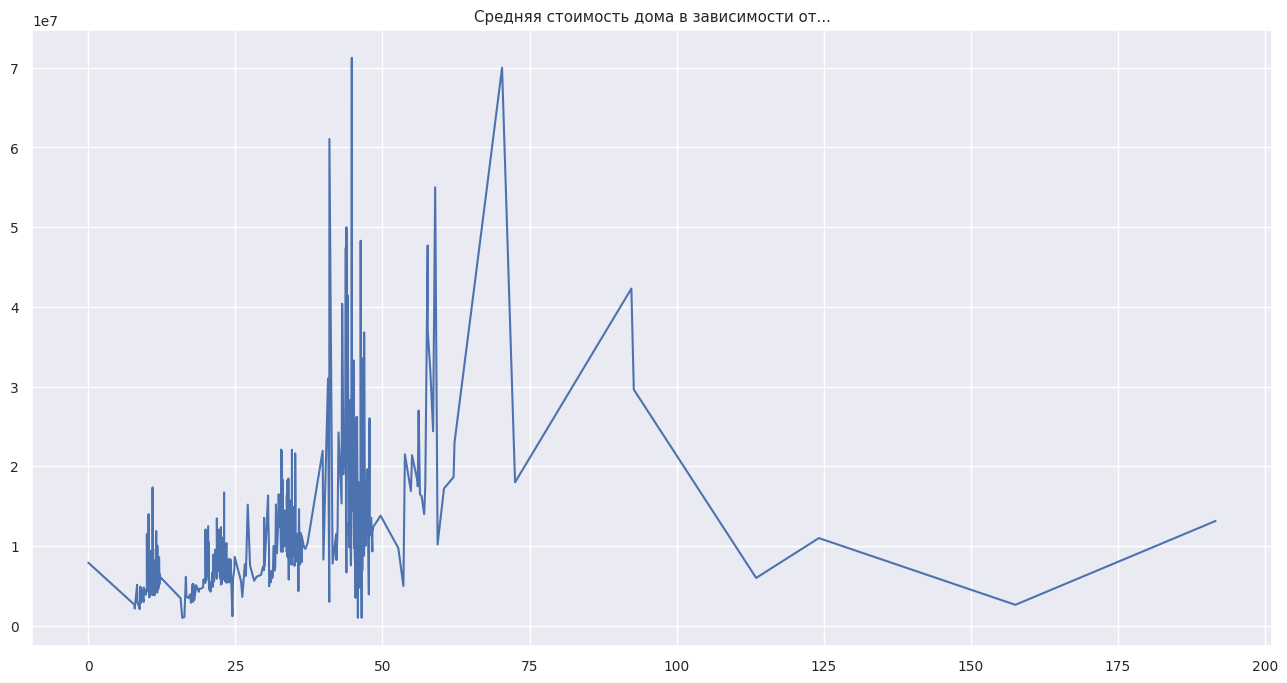

In [18]:
plt.figure(figsize = (16,8))
plt.plot(df.groupby('Test3')['price_doc'].mean())
plt.title('Средняя стоимость дома в зависимости от...')
plt.show()

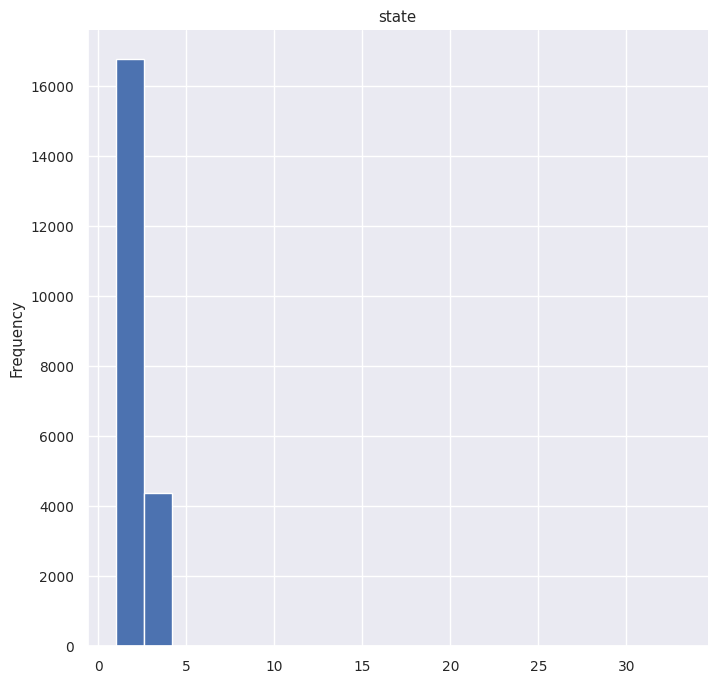

In [19]:
plt.figure(figsize = (8,8))
df['state'].plot(kind='hist', bins=20, title='state')
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-20-a7acbb4f3a29>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df,x='ExpensiveMeter1',y='price_doc',palette=sns.color_palette())
<ipython-input-20-a7acbb4f3a29>:1: UserWarning: 
The palette list has fewer values (10) than needed (357) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=df,x='ExpensiveMeter1',y='price_doc',palette=sns.color_palette())


<Axes: xlabel='ExpensiveMeter1', ylabel='price_doc'>

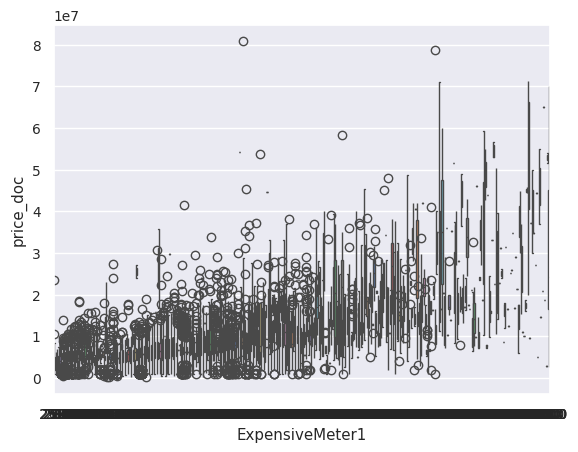

In [20]:
sns.boxplot(data=df, x='ExpensiveMeter1', y='price_doc', palette=sns.color_palette())

# Сабмит

In [39]:
submission = pd.read_csv('./gdrive/MyDrive/shift 2/submission.csv', index_col=0)

In [40]:
test_df = pd.read_csv('./gdrive/MyDrive/shift 2/test.csv', index_col=0)
test_df = change_df(test_df, True)

# Тестовый Датасет с заполненными ценами из тренировочного Датасета (для повторок)
# Получился с помощью спец. алгоритма нахождения дубликатов
test_patched_df = pd.read_csv('./gdrive/MyDrive/testPatched.csv', index_col=0)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [41]:
X = test_df.iloc[:, :]

In [42]:
y_pred_model_lgb = model_lgb.predict(X)
y_pred_model_xgboost = model_xgboost.predict(X)
y_pred_model_cat = model_cat.predict(X)

In [43]:
# Коэффициенты блендинга подобраны экспериментальным путем
prediction = 0.1 * y_pred_model_lgb + 0.7 * y_pred_model_xgboost + 0.2 * y_pred_model_cat

Замена результатов у наблюдений с известной ценой

In [44]:
test_preds = prediction
submission['price_doc'] = test_preds

#Если на это наблюдение есть известная цена, то ставим её
submission['price_doc'][test_patched_df['price_doc'] != 0] = test_patched_df['price_doc']

In [38]:
submission.to_csv('submission.csv')
!zip submission.zip submission.csv
files.download('submission.zip')

updating: submission.csv (deflated 51%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>